[<img src="https://deepnote.com/buttons/launch-in-deepnote-small.svg">](https://deepnote.com/launch?url=https%3A%2F%2Fgithub.com%2Fgordicaleksa%2Fget-started-with-JAX%2Fblob%2Fmain%2FTutorial_4_Flax_Zero2Hero_Colab.ipynb)

<a href="https://colab.research.google.com/github/gordicaleksa/get-started-with-JAX/blob/main/Tutorial_4_Flax_Zero2Hero_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flax: From Zero to Hero!

This notebook heavily relies on the [official Flax docs](https://flax.readthedocs.io/en/latest/) and [examples](https://github.com/google/flax/blob/main/examples/)  + some additional code/modifications, comments/notes, etc.

### Enter Flax - the basics ❤️

Before you jump into the Flax world I strongly recommend you check out my JAX tutorials, as I won't be covering the details of JAX here.

* (Tutorial 1) ML with JAX: From Zero to Hero ([video](https://www.youtube.com/watch?v=SstuvS-tVc0), [notebook](https://github.com/gordicaleksa/get-started-with-JAX/blob/main/Tutorial_1_JAX_Zero2Hero_Colab.ipynb))
* (Tutorial 2) ML with JAX: from Hero to Hero Pro+ ([video](https://www.youtube.com/watch?v=CQQaifxuFcs), [notebook](https://github.com/gordicaleksa/get-started-with-JAX/blob/main/Tutorial_2_JAX_HeroPro%2B_Colab.ipynb))
* (Tutorial 3) ML with JAX: Coding a Neural Network from Scratch in Pure JAX ([video](https://www.youtube.com/watch?v=6_PqUPxRmjY), [notebook](https://github.com/gordicaleksa/get-started-with-JAX/blob/main/Tutorial_3_JAX_Neural_Network_from_Scratch_Colab.ipynb))

That out of the way - let's start with the basics!

In [2]:
# Install Flax and JAX
!pip install --upgrade -q "jax[cuda11_cudnn805]" -f https://storage.googleapis.com/jax-releases/jax_releases.html
!pip install --upgrade -q git+https://github.com/google/flax.git
!pip install --upgrade -q git+https://github.com/deepmind/dm-haiku  # Haiku is here just for comparison purposes

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done


In [3]:
import jax
from jax import lax, random, numpy as jnp

# NN lib built on top of JAX developed by Google Research (Brain team)
# Flax was "designed for flexibility" hence the name (Flexibility + JAX -> Flax)
import flax
from flax.core import freeze, unfreeze
from flax import linen as nn  # nn notation also used in PyTorch and in Flax's older API
from flax.training import train_state  # a useful dataclass to keep train state

# DeepMind's NN JAX lib - just for comparison purposes, we're not learning Haiku here
import haiku as hk

# JAX optimizers - a separate lib developed by DeepMind
import optax

# Flax doesn't have its own data loading functions - we'll be using PyTorch dataloaders
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

# Python libs
import functools  # useful utilities for functional programs
from typing import Any, Callable, Sequence, Optional

# Other important 3rd party libs
import numpy as np
import matplotlib.pyplot as plt

The goal of this notebook is to get you started with Flax!

I'll only cover the most essential parts of Flax (and Optax) - just as much as needed to get you started with training NNs!

In [4]:
# Let's start with the simplest model possible: a single feed-forward layer (linear regression)
model = nn.Dense(features=5)   # a linear layer without an activation function, 5 represents the number outputs from the layer

# All of the Flax NN layers inherit from the Module class (similarly to PyTorch)
print(nn.Dense.__bases__)

(<class 'flax.linen.module.Module'>,)


So how can we do inference with this simple model? 2 steps: init and apply!

In [5]:
# Step 1: init
seed = 23
key1, key2 = random.split(random.PRNGKey(seed))
x = random.normal(key1, (10,))  # create a dummy input, a 10-dimensional random vector

# Initialization call - this gives us the actual model weights
# (remember JAX handles state externally!)
y, params = model.init_with_output(key2, x)  # have to pass a random seed
print(y)
print(jax.tree_map(lambda x: x.shape, params))

# Note1: automatic shape inference                              NB, comes from x
# Note2: immutable structure (hence FrozenDict)
# Note3: init_with_output if you care, for whatever reason, about the output here

[-1.2137771  -0.36633095  0.06677863 -2.0143983  -0.32107353]
FrozenDict({
    params: {
        bias: (5,),
        kernel: (10, 5),
    },
})


In [6]:
# Step 2: apply
y = model.apply(params, x)  # this is how you run prediction in Flax, state is external!
print(y)

[-1.2137771  -0.36633095  0.06677863 -2.0143983  -0.32107353]


In [7]:
try:
    y = model(x)  # this doesn't work anymore (bye bye PyTorch syntax)
except Exception as e:
    print(e)

Can't call compact methods on unbound modules (https://flax.readthedocs.io/en/latest/api_reference/flax.errors.html#flax.errors.CallCompactUnboundModuleError)


In [8]:
# Haiku seems to be simpler but less effective
#@title Haiku vs Flax solution
model = hk.transform(lambda x: hk.Linear(output_size=5)(x))

seed = 23
key1, key2 = random.split(random.PRNGKey(seed))
x = random.normal(key1, (10,))  # create a dummy input, a 10-dimensional random vector

params = model.init(key2, x)
out = model.apply(params, None, x)
print(out)

print(hk.Linear.__bases__)

[ 0.06356492  0.90469664  1.2192199  -0.28187284 -1.2322013 ]
(<class 'haiku._src.module.Module'>,)


All of this might (initially!) be overwhelming if you're used to stateful, object-oriented paradigm.

What Flax offers is high performance and flexibility (similarly to JAX).

Here are some [benchmark numbers](https://github.com/huggingface/transformers/tree/master/examples/flax/text-classification) from the HuggingFace team.

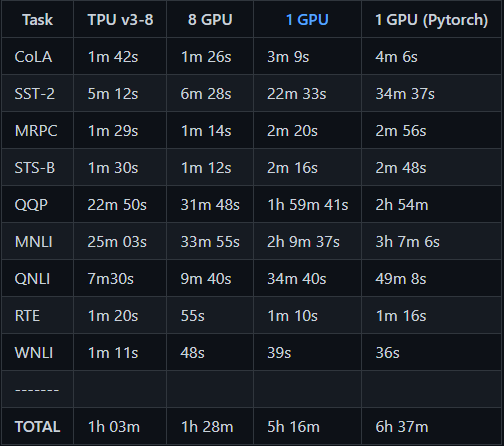

Now that we have a an answer to "why should I learn Flax?" - let's start our descent into Flaxlandia!

### A toy example 🚚 - training a linear regression model

We'll first implement a pure-JAX appoach and then we'll do it the Flax-way.

HEADS UP, the next three sections use a model to create the dataset!

In [11]:
# Defining a toy dataset
n_samples = 1500
x_dim = 2  # putting small numbers here so that we can visualize the data easily
y_dim = 1
noise_amplitude = 0.1

# Generate (random) ground truth W and b
# Note: we could get W, b from a randomely initialized nn.Dense here, being closer to JAX for now
key, w_key, b_key = random.split(random.PRNGKey(seed), num=3)
W = random.normal(w_key, (x_dim, y_dim))  # weight
b = random.normal(b_key, (y_dim,))  # bias

# This is the structure that Flax expects (recall from the previous section!)
true_params = freeze({'params': {'bias': b, 'kernel': W}})

# Generate samples with additional noise
key, x_key, noise_key = random.split(key, num=3)
xs = random.normal(x_key, (n_samples, x_dim))
ys = jnp.dot(xs, W) + b
ys += noise_amplitude * random.normal(noise_key, (n_samples, y_dim))
print(f'xs shape = {xs.shape} ; ys shape = {ys.shape}')

xs shape = (1500, 2) ; ys shape = (1500, 1)


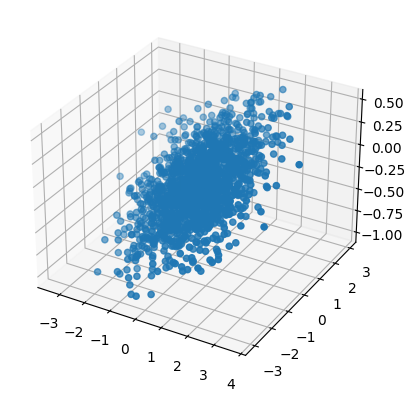

In [12]:
# Let's visualize our data (becoming one with the data paradigm <3)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
assert xs.shape[-1] == 2 and ys.shape[-1] == 1  # low dimensional data so that we can plot it
ax.scatter(xs[:, 0], xs[:, 1], zs=ys)

# todo: exercise - let's show that our data lies on the 2D plane embedded in 3D
# option 1: analytic approach. Write the equation of how we obtain y from x
# option 2: data-driven approach. Do a lof of points and see the plane

In [13]:
def make_mse_loss(xs, ys):

    def mse_loss(params):
        """Gives the value of the loss on the (xs, ys) dataset for the given model (params)."""

        # Define the squared loss for a single pair (x,y)
        def squared_error(x, y):
            pred = model.apply(params, x)
            # Inner because 'y' could have in general more than 1 dims
            return jnp.inner(y-pred, y-pred) / 2.0

        # Batched version via vmap
        return jnp.mean(jax.vmap(squared_error)(xs, ys), axis=0)

    return jax.jit(mse_loss)  # and finally we jit the result (mse_loss is a pure function)

mse_loss = make_mse_loss(xs, ys)
value_and_grad_fn = jax.value_and_grad(mse_loss)   # this thing already contains the data and just needs the parameters

Now he makes the model to fit the data.

In [15]:
# Let's reuse the simple feed-forward layer since it trivially implements linear regression
model = nn.Dense(features=y_dim)
params = model.init(key, xs)
print(f'Initial params = {params}')

# Let's set some reasonable hyperparams
lr = 0.3
epochs = 20
log_period_epoch = 5

print('-' * 50)
for epoch in range(epochs):
    loss, grads = value_and_grad_fn(params)
    # SGD (closer to JAX again, but we'll progressively go towards how stuff is done in Flax)
    params = jax.tree_map(lambda p, g: p - lr * g, params, grads)

    if epoch % log_period_epoch == 0:
        print(f'epoch {epoch}, loss = {loss}')

print('-' * 50)
print(f'Learned params = {params}')
print(f'Gt params = {true_params}')

Initial params = FrozenDict({
    params: {
        kernel: Array([[1.1737938],
               [0.4118816]], dtype=float32),
        bias: Array([0.], dtype=float32),
    },
})
--------------------------------------------------
epoch 0, loss = 0.6885039806365967
epoch 5, loss = 0.0200005155056715
epoch 10, loss = 0.005448050331324339
epoch 15, loss = 0.0051234569400548935
--------------------------------------------------
Learned params = FrozenDict({
    params: {
        bias: Array([-0.2549984], dtype=float32),
        kernel: Array([[0.08552127],
               [0.21779607]], dtype=float32),
    },
})
Gt params = FrozenDict({
    params: {
        bias: Array([-0.25356248], dtype=float32),
        kernel: Array([[0.08546512],
               [0.22107157]], dtype=float32),
    },
})


Now let's do the same thing but this time with dedicated optimizers!

Enter DeepMind's optax! ❤️🔥

In [ ]:
opt_sgd = optax.sgd(learning_rate=lr)
opt_state = opt_sgd.init(params)  # always the same pattern - handling state externally
print(opt_state)
# todo: exercise - compare Adam's and SGD's states

In [ ]:
params = model.init(key, xs)  # let's start with fresh params again

for epoch in range(epochs):
    loss, grads = value_and_grad_fn(params)
    updates, opt_state = opt_sgd.update(grads, opt_state)  # arbitrary optim logic! gives the updated parameter gradients
    params = optax.apply_updates(params, updates)   # uses the updated gradients to update the params

    if epoch % log_period_epoch == 0:
        print(f'epoch {epoch}, loss = {loss}')

# Note 1: as expected we get the same loss values
# Note 2: we'll later see more concise ways to handle all of these state components (hint: TrainState)

In this toy SGD example Optax may not seem that useful but it's very powerful.

You can build arbitrary optimizers with arbitrary hyperparam schedules, chaining, param freezing, etc. You can check the [official docs here](https://optax.readthedocs.io/en/latest/).

In [ ]:
#@title Optax Advanced Examples
# This cell won't "compile" (no ml_collections package) and serves just as an example

# Example from Flax (ImageNet example)
# https://github.com/google/flax/blob/main/examples/imagenet/train.py#L88
def create_learning_rate_fn(
    config: ml_collections.ConfigDict,
    base_learning_rate: float,
    steps_per_epoch: int):
  """Create learning rate schedule."""
  warmup_fn = optax.linear_schedule(
      init_value=0., end_value=base_learning_rate,
      transition_steps=config.warmup_epochs * steps_per_epoch)
  cosine_epochs = max(config.num_epochs - config.warmup_epochs, 1)
  cosine_fn = optax.cosine_decay_schedule(
      init_value=base_learning_rate,
      decay_steps=cosine_epochs * steps_per_epoch)
  schedule_fn = optax.join_schedules(
      schedules=[warmup_fn, cosine_fn],
      boundaries=[config.warmup_epochs * steps_per_epoch])
  return schedule_fn

tx = optax.sgd(
      learning_rate=learning_rate_fn,
      momentum=config.momentum,
      nesterov=True,
)

# Example from Haiku (ImageNet example)
# https://github.com/deepmind/dm-haiku/blob/main/examples/imagenet/train.py#L116
def make_optimizer() -> optax.GradientTransformation:
  """SGD with nesterov momentum and a custom lr schedule."""
  return optax.chain(
      optax.trace(
          decay=FLAGS.optimizer_momentum,
          nesterov=FLAGS.optimizer_use_nesterov),
      optax.scale_by_schedule(lr_schedule), optax.scale(-1))

Now let's go beyond these extremely simple models!

### Creating custom models ⭐

In [16]:
class MLP(nn.Module):
    num_neurons_per_layer: Sequence[int]  # data field (nn.Module is Python's dataclass)

    def setup(self):  # because dataclass is implicitly using the  __init__ function... :')
        self.layers = [nn.Dense(n) for n in self.num_neurons_per_layer]

    def __call__(self, x):
        activation = x
        for i, layer in enumerate(self.layers):
            activation = layer(activation)
            if i != len(self.layers) - 1:
                activation = nn.relu(activation)
        return activation

x_key, init_key = random.split(random.PRNGKey(seed))

model = MLP(num_neurons_per_layer=[16, 8, 1])  # define an MLP model
x = random.uniform(x_key, (4,4))  # dummy input
params = model.init(init_key, x)  # initialize via init
y = model.apply(params, x)  # do a forward pass via apply

print(jax.tree_map(jnp.shape, params))
print(f'Output: {y}')

# todo: exercise - use @nn.compact pattern instead
# todo: check out https://realpython.com/python-data-classes/

FrozenDict({
    params: {
        layers_0: {
            bias: (16,),
            kernel: (4, 16),
        },
        layers_1: {
            bias: (8,),
            kernel: (16, 8),
        },
        layers_2: {
            bias: (1,),
            kernel: (8, 1),
        },
    },
})
Output: [[0.35997367]
 [0.19171566]
 [0.32771796]
 [0.46014398]]


Great!

Now that we know how to build more complex models let's dive deeper and understand how the 'nn.Dense' module is designed itself.

#### Introducing "param"

In [17]:
class MyDenseImp(nn.Module):
    num_neurons: int
    weight_init: Callable = nn.initializers.lecun_normal()
    bias_init: Callable = nn.initializers.zeros

    @nn.compact
    def __call__(self, x):
        weight = self.param('weight',  # parametar name (as it will appear in the FrozenDict)
                self.weight_init,  # initialization function, RNG passed implicitly through init fn
                (x.shape[-1], self.num_neurons))  # shape info
        bias = self.param('bias', self.bias_init, (self.num_neurons,))

        return jnp.dot(x, weight)  + bias

x_key, init_key = random.split(random.PRNGKey(seed))

model = MyDenseImp(num_neurons=3)  # initialize the model
x = random.uniform(x_key, (4,4))  # dummy input
params = model.init(init_key, x)  # initialize via init
y = model.apply(params, x)  # do a forward pass via apply

print(jax.tree_map(jnp.shape, params))
print(f'Output: {y}')

# todo: exercise - check out the source code:
# https://github.com/google/flax/blob/main/flax/linen/linear.py
# https://github.com/google/jax/blob/main/jax/_src/nn/initializers.py#L150 <- to see why lecun_normal() vs zeros (no brackets)

FrozenDict({
    params: {
        bias: (3,),
        weight: (4, 3),
    },
})
Output: [[-0.4543119   0.14070596 -0.13996765]
 [-0.326043   -0.02913586  0.21127704]
 [-0.16531755  0.2607744  -0.37982282]
 [-0.01778071  0.4073724  -0.10995425]]


In [18]:
from inspect import signature

# You can see it expects a PRNG key and it is passed implicitly through the init fn (same for zeros)
print(signature(nn.initializers.lecun_normal()))

(key: jax._src.prng.PRNGKeyArray, shape: Sequence[Union[int, Any]], dtype: Any = <class 'jax.numpy.float64'>) -> Any


So far we've only seen **trainable** params.

ML models often times have variables which are part of the state but are not optimized via gradient descent.

Let's see how we can handle them using a simple (and contrived) example!

#### Introducing "variable"

*Note on terminology: variable is a broader term and it includes both params (trainable variables) as well as non-trainable vars.*


EMA - exponentially moving average

In [19]:
class BiasAdderWithRunningMean(nn.Module):
    decay: float = 0.99

    @nn.compact
    def __call__(self, x):
        is_initialized = self.has_variable('batch_stats', 'ema')

        # 'batch_stats' is not an arbitrary name!
        # Flax uses that name in its implementation of BatchNorm (hard-coded, probably not the best of designs?)
        ema = self.variable('batch_stats', 'ema', lambda shape: jnp.zeros(shape), x.shape[1:])

        # self.param will by default add this variable to 'params' collection (vs 'batch_stats' above)
        # Again some idiosyncrasies here we need to pass a key even though we don't actually use it...
        bias = self.param('bias', lambda key, shape: jnp.zeros(shape), x.shape[1:])

        if is_initialized:
            # self.variable returns a reference hence .value
            ema.value = self.decay * ema.value + (1.0 - self.decay) * jnp.mean(x, axis=0, keepdims=True)

        return x - ema.value + bias

x_key, init_key = random.split(random.PRNGKey(seed))

model = BiasAdderWithRunningMean()
x = random.uniform(x_key, (10,4))  # dummy input
variables = model.init(init_key, x)
print(f'Multiple collections = {variables}')  # we can now see a new collection 'batch_stats'

# We have to use mutable since regular params are not modified during the forward
# pass, but these variables are. We can't keep state internally (because JAX) so we have to return it.
y, updated_non_trainable_params = model.apply(variables, x, mutable=['batch_stats'])
print(updated_non_trainable_params)

Multiple collections = FrozenDict({
    batch_stats: {
        ema: Array([0., 0., 0., 0.], dtype=float32),
    },
    params: {
        bias: Array([0., 0., 0., 0.], dtype=float32),
    },
})
FrozenDict({
    batch_stats: {
        ema: Array([[0.00421787, 0.00597094, 0.00638907, 0.00699901]], dtype=float32),
    },
})


In [20]:
# Let's see how we could train such model!
def update_step(opt, apply_fn, x, opt_state, params, non_trainable_params):

    def loss_fn(params):
        y, updated_non_trainable_params = apply_fn(
            {'params': params, **non_trainable_params},
            x, mutable=list(non_trainable_params.keys()))

        loss = ((x - y) ** 2).sum()  # not doing anything really, just for the demo purpose

        return loss, updated_non_trainable_params

    (loss, non_trainable_params), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

    return opt_state, params, non_trainable_params  # all of these represent the state - ugly, for now

model = BiasAdderWithRunningMean()
x = jnp.ones((10,4))  # dummy input, using ones because it's easier to see what's going on

variables = model.init(random.PRNGKey(seed), x)
non_trainable_params, params = variables.pop('params')
del variables  # delete variables to avoid wasting resources (this pattern is used in the official code)

sgd_opt = optax.sgd(learning_rate=0.1)  # originally you'll see them use the 'tx' naming (from opTaX)
opt_state = sgd_opt.init(params)

for _ in range(3):
    # We'll later see how TrainState abstraction will make this step much more elegant!
    opt_state, params, non_trainable_params = update_step(sgd_opt, model.apply, x, opt_state, params, non_trainable_params)
    print(non_trainable_params)

FrozenDict({
    batch_stats: {
        ema: Array([[0.01, 0.01, 0.01, 0.01]], dtype=float32),
    },
})
FrozenDict({
    batch_stats: {
        ema: Array([[0.0199, 0.0199, 0.0199, 0.0199]], dtype=float32),
    },
})
FrozenDict({
    batch_stats: {
        ema: Array([[0.029701, 0.029701, 0.029701, 0.029701]], dtype=float32),
    },
})


Let's go a level up in abstraction again now that we understand params and variables!

Certain layers like BatchNorm will use variables in the background.

Let's see a last example that is conceptually as complicated as it gets when it comes to Flax's idiosyncrasies, and high-level at the same time.

In [21]:
class DDNBlock(nn.Module):
    """Dense, dropout + batchnorm combo.

    Contains trainable variables (params), non-trainable variables (batch stats),
    and stochasticity in the forward pass (because of dropout).
    """
    num_neurons: int
    training: bool

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.num_neurons)(x)
        x = nn.Dropout(rate=0.5, deterministic=not self.training)(x)
        x = nn.BatchNorm(use_running_average=not self.training)(x)
        return x

key1, key2, key3, key4 = random.split(random.PRNGKey(seed), 4)

model = DDNBlock(num_neurons=3, training=True)
x = random.uniform(key1, (3,4,4))

# New: because of Dropout we now have to include its unique key - kinda weird, but you get used to it
variables = model.init({'params': key2, 'dropout': key3}, x)
print(variables)

# And same here, everything else remains the same as the previous example
y, non_trainable_params = model.apply(variables, x, rngs={'dropout': key4}, mutable=['batch_stats'])

# Let's run these model variables during "evaluation":
eval_model = DDNBlock(num_neurons=3, training=False)
# Because training=False we don't have stochasticity in the forward pass neither do we update the stats
y = eval_model.apply(variables, x)

FrozenDict({
    params: {
        Dense_0: {
            kernel: Array([[-0.7563737 ,  0.01997767,  0.04605456],
                   [ 0.6576447 , -0.7379195 , -0.3011639 ],
                   [ 0.8068488 ,  0.7780827 ,  0.0981377 ],
                   [ 0.15413885,  0.1724395 ,  0.44406682]], dtype=float32),
            bias: Array([0., 0., 0.], dtype=float32),
        },
        BatchNorm_0: {
            scale: Array([1., 1., 1.], dtype=float32),
            bias: Array([0., 0., 0.], dtype=float32),
        },
    },
    batch_stats: {
        BatchNorm_0: {
            mean: Array([0., 0., 0.], dtype=float32),
            var: Array([1., 1., 1.], dtype=float32),
        },
    },
})


### A fully-fledged CNN on MNIST example in Flax! 💥

Modified the official MNIST example here: https://github.com/google/flax/tree/main/examples/mnist

We'll be using PyTorch dataloading instead of TFDS.

Let's start by defining a model:

In [22]:
class CNN(nn.Module):  # lots of hardcoding, but it serves a purpose for a simple demo
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = x.reshape((x.shape[0], -1))  # flatten
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=10)(x)
        x = nn.log_softmax(x)
        return x

Let's add the data loading support in PyTorch!

I'll be reusing code from [tutorial #3](https://github.com/gordicaleksa/get-started-with-JAX/blob/main/Tutorial_3_JAX_Neural_Network_from_Scratch_Colab.ipynb):

In [23]:
def custom_transform(x):
    # A couple of modifications here compared to tutorial #3 since we're using a CNN
    # Input: (28, 28) uint8 [0, 255] torch.Tensor, Output: (28, 28, 1) float32 [0, 1] np array
    return np.expand_dims(np.array(x, dtype=np.float32), axis=2) / 255.

def custom_collate_fn(batch):
    """Provides us with batches of numpy arrays and not PyTorch's tensors."""
    transposed_data = list(zip(*batch))

    labels = np.array(transposed_data[1])
    imgs = np.stack(transposed_data[0])

    return imgs, labels

mnist_img_size = (28, 28, 1)
batch_size = 128

train_dataset = MNIST(root='train_mnist', train=True, download=True, transform=custom_transform)
test_dataset = MNIST(root='test_mnist', train=False, download=True, transform=custom_transform)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, collate_fn=custom_collate_fn, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, collate_fn=custom_collate_fn, drop_last=True)

# optimization - loading the whole dataset into memory
train_images = jnp.array(train_dataset.data)
train_lbls = jnp.array(train_dataset.targets)

# np.expand_dims is to convert shape from (10000, 28, 28) -> (10000, 28, 28, 1)
# We don't have to do this for training images because custom_transform does it for us.
test_images = np.expand_dims(jnp.array(test_dataset.data), axis=3)
test_lbls = jnp.array(test_dataset.targets)

100%|██████████| 9912422/9912422 [00:00<00:00, 222718274.88it/s]

Extracting train_mnist/MNIST/raw/train-images-idx3-ubyte.gz to train_mnist/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 107580545.14it/s]


Extracting train_mnist/MNIST/raw/train-labels-idx1-ubyte.gz to train_mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 64999590.19it/s]

Extracting train_mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to train_mnist/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 4339528.19it/s]


Extracting train_mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to train_mnist/MNIST/raw



100%|██████████| 9912422/9912422 [00:00<00:00, 198895443.52it/s]

Extracting test_mnist/MNIST/raw/train-images-idx3-ubyte.gz to test_mnist/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 89597406.67it/s]

Extracting test_mnist/MNIST/raw/train-labels-idx1-ubyte.gz to test_mnist/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 61434725.88it/s]


Extracting test_mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to test_mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19700650.23it/s]


Extracting test_mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to test_mnist/MNIST/raw



7


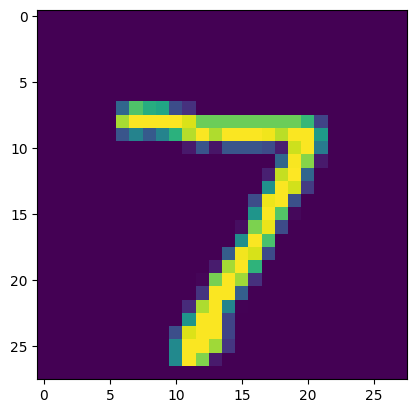

In [24]:
# Visualize a single image
imgs, lbls = next(iter(test_loader))
img = imgs[0].reshape(mnist_img_size)[:, :, 0]
gt_lbl = lbls[0]

print(gt_lbl)
plt.imshow(img); plt.show()

Great - we have our data pipeline ready and the model architecture defined.

Now let's define core training functions:

In [25]:
@jax.jit
def train_step(state, imgs, gt_labels):
    def loss_fn(params):
        logits = CNN().apply({'params': params}, imgs)
        one_hot_gt_labels = jax.nn.one_hot(gt_labels, num_classes=10)
        loss = -jnp.mean(jnp.sum(one_hot_gt_labels * logits, axis=-1))
        return loss, logits

    (_, logits), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)  # this is the whole update now! concise!
    metrics = compute_metrics(logits=logits, gt_labels=gt_labels)  # duplicating loss calculation but it's a bit cleaner
    return state, metrics

@jax.jit
def eval_step(state, imgs, gt_labels):
    logits = CNN().apply({'params': state.params}, imgs)
    return compute_metrics(logits=logits, gt_labels=gt_labels)

In [26]:
def train_one_epoch(state, dataloader, epoch):
    """Train for 1 epoch on the training set."""
    batch_metrics = []
    for cnt, (imgs, labels) in enumerate(dataloader):
        state, metrics = train_step(state, imgs, labels)
        batch_metrics.append(metrics)

    # Aggregate the metrics
    batch_metrics_np = jax.device_get(batch_metrics)  # pull from the accelerator onto host (CPU)
    epoch_metrics_np = {
        k: np.mean([metrics[k] for metrics in batch_metrics_np])
        for k in batch_metrics_np[0]
    }

    return state, epoch_metrics_np

def evaluate_model(state, test_imgs, test_lbls):
    """Evaluate on the validation set."""
    metrics = eval_step(state, test_imgs, test_lbls)
    metrics = jax.device_get(metrics)  # pull from the accelerator onto host (CPU)
    metrics = jax.tree_map(lambda x: x.item(), metrics)  # np.ndarray -> scalar
    return metrics

In [27]:
# This one will keep things nice and tidy compared to our previous examples
def create_train_state(key, learning_rate, momentum):
    cnn = CNN()
    params = cnn.init(key, jnp.ones([1, *mnist_img_size]))['params']
    sgd_opt = optax.sgd(learning_rate, momentum)
    # TrainState is a simple built-in wrapper class that makes things a bit cleaner
    return train_state.TrainState.create(apply_fn=cnn.apply, params=params, tx=sgd_opt)

def compute_metrics(*, logits, gt_labels):
    one_hot_gt_labels = jax.nn.one_hot(gt_labels, num_classes=10)

    loss = -jnp.mean(jnp.sum(one_hot_gt_labels * logits, axis=-1))
    accuracy = jnp.mean(jnp.argmax(logits, -1) == gt_labels)

    metrics = {
        'loss': loss,
        'accuracy': accuracy,
    }
    return metrics

In [28]:
# Finally let's define the high-level training/val loops
seed = 0  # needless to say these should be in a config or defined like flags
learning_rate = 0.1
momentum = 0.9
num_epochs = 2
batch_size = 32

train_state = create_train_state(jax.random.PRNGKey(seed), learning_rate, momentum)

for epoch in range(1, num_epochs + 1):
    train_state, train_metrics = train_one_epoch(train_state, train_loader, epoch)
    print(f"Train epoch: {epoch}, loss: {train_metrics['loss']}, accuracy: {train_metrics['accuracy'] * 100}")

    test_metrics = evaluate_model(train_state, test_images, test_lbls)
    print(f"Test epoch: {epoch}, loss: {test_metrics['loss']}, accuracy: {test_metrics['accuracy'] * 100}")

# todo: exercise - how would we go about adding dropout? What about BatchNorm? What would have to change?

Train epoch: 1, loss: 0.2454100102186203, accuracy: 92.69664883613586
Test epoch: 1, loss: 14.557336807250977, accuracy: 97.39999771118164
Train epoch: 2, loss: 0.05074062570929527, accuracy: 98.45085740089417
Test epoch: 2, loss: 8.129578590393066, accuracy: 98.47999811172485


Bonus point: a walk-through the "non-toy", distributed ImageNet CNN training example.

Head over to https://github.com/google/flax/tree/main/examples/imagenet

You'll keep seeing the same pattern/structure in all official Flax examples.

### Further learning resources 📚

Aside from the [official docs](https://flax.readthedocs.io/en/latest/) and [examples](https://github.com/google/flax/tree/main/examples) I found [HuggingFace's Flax examples](https://github.com/huggingface/transformers/tree/master/examples/flax) and the resources from their ["community week"](https://github.com/huggingface/transformers/tree/master/examples/research_projects/jax-projects) useful as well.

Finally, [source code](https://github.com/google/flax) is also your friend, as the library is still evolving.

### Connect with me ❤️

Last but not least I regularly post AI-related stuff (paper summaries, AI news, etc.) on my Twitter/LinkedIn. We also have an ever increasing Discord community (1600+ members at the time of writing this). If you care about any of these I encourage you to connect!

Social: <br/>
💼 LinkedIn - https://www.linkedin.com/in/aleksagordic/ <br/>
🐦 Twitter - https://twitter.com/gordic_aleksa <br/>
👨‍👩‍👧‍👦 Discord - https://discord.gg/peBrCpheKE <br/>
🙏 Patreon - https://www.patreon.com/theaiepiphany <br/>

Content: <br/>
📺 YouTube - https://www.youtube.com/c/TheAIEpiphany/ <br/>
📚 Medium - https://gordicaleksa.medium.com/ <br/>
💻 GitHub - https://github.com/gordicaleksa <br/>
📢 AI Newsletter - https://aiepiphany.substack.com/ <br/>